# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Final Project: Mobility Data and Coronavirus Cases in the United States

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2.4pt">

In [33]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [259]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
import tensorflow as tf


In [40]:
# read in the dataframes
national_df = pd.read_csv("../../02_Data/05_Mobility/US_Mobility_Report.csv")
state_df = pd.read_csv("../../02_Data/05_Mobility/US_States_Mobility_Report.csv")
county_df = pd.read_csv("../../02_Data/05_Mobility/US_Regional_Mobility_Report.csv")
cases_df = pd.read_csv("../../02_Data/01_Covid/covid_us_county.csv")

In [41]:
print(national_df.shape)
print(state_df.shape)
print(county_df.shape)
print(cases_df.shape)

(263, 8)
(13413, 8)
(646449, 10)
(945220, 9)


In [42]:
county_df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Alabama,Autauga County,1001.0,2020-02-15,5,7,34,-10,-4,7
1,Alabama,Autauga County,1001.0,2020-02-16,0,1,-23,-10,-4,7
2,Alabama,Autauga County,1001.0,2020-02-17,8,0,34,-10,-27,5
3,Alabama,Autauga County,1001.0,2020-02-18,-2,0,34,-10,2,0
4,Alabama,Autauga County,1001.0,2020-02-19,-2,0,34,-10,2,0


In [ ]:
cases_df.head()

In [5]:
# check for null columns
null_columns = cases_df.columns[cases_df.isnull().any()]
cases_df[null_columns].isnull().sum()

county        1132
cases            1
state_code    1982
deaths           1
dtype: int64

In [6]:
# drop all null columns
cases_df = cases_df.dropna()
cases_df.isnull().any()
# cases_df.loc[cases_df['state_code'].isnull()]

fips          False
county        False
state         False
lat           False
long          False
date          False
cases         False
state_code    False
deaths        False
dtype: bool

In [43]:
cases_df.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


Let's join the dataframes by fips code, states, counties, and date.

In [49]:
df = county_df.merge(cases_df, left_on=['census_fips_code', 'sub_region_1', 'sub_region_2', 'date'], right_on=['fips', 'state', 'county', 'date'])

In [50]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,county,state,lat,long,cases,state_code,deaths
0,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
1,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
2,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
3,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0
4,Alaska,Anchorage,2020.0,2020-02-19,-1,-3,-8,5,1,1,2020.0,Anchorage,Alaska,61.149982,-149.142699,0,AK,0


In [320]:
type(df.iloc[0]['date'])
df_copy = df.copy()

In [329]:
# df.groupby('fips', as_index=False).mean()['retail_and_recreation']

In [70]:
# save all predictors in its own variable
predictors_list = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']

In [331]:
df.groupby('fips', as_index=False).shift(periods=1, fill_value=0)

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,county,state,cases,state_code,deaths
0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0
1,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,2020.0,Anchorage,Alaska,0,AK,0
2,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,2020.0,Anchorage,Alaska,0,AK,0
3,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,2020.0,Anchorage,Alaska,0,AK,0
4,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,2020.0,Anchorage,Alaska,0,AK,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10089,Virginia,Winchester,51840.0,2020-10-25,-20,-5,34,-10,-16,7,51840.0,Winchester,Virginia,596,VA,5
10090,Virginia,Winchester,51840.0,2020-10-26,-13,-9,34,-10,-18,5,51840.0,Winchester,Virginia,607,VA,5
10091,Virginia,Winchester,51840.0,2020-10-27,-13,-7,34,-10,-21,5,51840.0,Winchester,Virginia,611,VA,5
10092,Virginia,Winchester,51840.0,2020-10-28,-10,-2,34,-10,-23,5,51840.0,Winchester,Virginia,617,VA,5


In [334]:
# add in the 7 day average for the cases and deaths
df['cases_7day_ave'] = df.groupby('fips', as_index=False)['cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)
df['deaths_7day_ave'] = df.groupby('fips', as_index=False)['deaths'].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)

In [343]:
# now do the same for the 6 predictors
for i in range(len(predictors_list)):
    df[f'{predictors_list[i]}_7day_ave'] = df.groupby('fips', as_index=False)[predictors_list[i]].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)

In [344]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,state_code,deaths,cases_7day_ave,deaths_7day_ave,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
0,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,...,AK,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,...,AK,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,...,AK,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,...,AK,0,0.0,0.0,2.714286,0.571429,2.571429,1.428571,-3.428571,1.714286
4,Alaska,Anchorage,2020.0,2020-02-19,-1,-3,-8,5,1,1,...,AK,0,0.0,0.0,2.857143,0.571429,2.714286,1.428571,-3.000000,1.571429


Let's include facemask data below.

In [345]:
# facemask
df_facemask = pd.read_csv(r"../../02_Data/07_Facemask/county_facemask.csv",index_col=0)
df_facemask['facemask_score']=1*df_facemask['facemask_never']+2*df_facemask['facemask_rarely']+3*df_facemask['facemask_sometimes']+4*df_facemask['facemask_frequently']+5*df_facemask['facemask_always']
df_facemask=df_facemask.drop(columns='countyfp')
df_facemask.describe()

,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,fips,facemask_score
count,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,0.079940,0.082919,0.121318,0.207725,0.508094,30383.649268,3.981097
std,0.058538,0.055464,0.058011,0.063571,0.152191,15162.508374,0.413002
min,0.000000,0.000000,0.001000,0.029000,0.115000,1001.000000,2.433000
25%,0.034000,0.040000,0.079000,0.164000,0.393250,18177.500000,3.682000
50%,0.068000,0.073000,0.115000,0.204000,0.497000,29176.000000,3.992000
75%,0.113000,0.115000,0.156000,0.247000,0.613750,45080.500000,4.291750
max,0.432000,0.384000,0.422000,0.549000,0.889000,56045.000000,4.849000


In [350]:
df = df.merge(df_facemask, on='fips')

In [52]:
# drop nulls -- I don't think there are any though
df = df.dropna()

In [346]:
# save raw df before work is done on it
df_raw = df.copy()

Now, hopefully, everything is matched up properly

In [352]:
# drop the lats and longs
df = df.drop(columns=['lat', 'long'])

In [353]:
df.describe()

,census_fips_code,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,fips,cases,deaths,...,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,facemask_score
count,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,...,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000,10094.000000
mean,41250.952942,-12.469388,0.197543,34.649198,-14.724787,-26.656430,7.548940,41250.952942,526.655439,9.152368,...,33.877735,-14.399049,-26.202143,7.375343,0.041748,0.045904,0.087556,0.201728,0.622946,4.317869
std,19828.063492,15.858597,9.710881,22.358072,15.791912,15.838237,4.240717,19828.063492,1087.052447,16.779480,...,17.279182,14.386024,13.927057,3.688501,0.037808,0.031883,0.053802,0.065314,0.118049,0.270985
min,2020.000000,-78.000000,-50.000000,-68.000000,-77.000000,-88.000000,-6.000000,2020.000000,0.000000,0.000000,...,-42.142857,-69.714286,-62.571429,-1.857143,0.000000,0.001000,0.001000,0.075000,0.352000,3.501000
25%,51510.000000,-19.000000,-4.000000,34.000000,-11.000000,-36.000000,7.000000,51510.000000,4.000000,0.000000,...,34.000000,-14.142857,-34.428571,7.000000,0.017000,0.025000,0.049000,0.163000,0.565000,4.217000
50%,51640.000000,-9.000000,2.000000,34.000000,-10.000000,-28.000000,7.000000,51640.000000,86.000000,1.000000,...,34.000000,-10.000000,-27.571429,7.000000,0.033000,0.039000,0.073000,0.196000,0.639000,4.380000
75%,51730.000000,-5.000000,3.000000,34.000000,-10.000000,-17.000000,7.000000,51730.000000,445.750000,8.000000,...,34.000000,-10.000000,-20.142857,7.428571,0.051000,0.056000,0.129000,0.225000,0.710000,4.505000
max,51840.000000,58.000000,88.000000,271.000000,46.000000,26.000000,34.000000,51840.000000,8149.000000,108.000000,...,150.571429,26.428571,20.857143,28.000000,0.184000,0.150000,0.235000,0.450000,0.833000,4.707000


In [356]:
# check for nulls
df.isnull().any().sum()

0

In [357]:
# split between predictors and response variables
X = df.drop(columns=['cases', 'deaths', 'cases_7day_ave', 'deaths_7day_ave'])
y = df[['cases', 'deaths', 'cases_7day_ave', 'deaths_7day_ave']]

In [358]:
y.head()

,cases,deaths,cases_7day_ave,deaths_7day_ave
0,0,0,0.0,0.0
1,0,0,0.0,0.0
2,0,0,0.0,0.0
3,0,0,0.0,0.0
4,0,0,0.0,0.0


In [359]:
# split between train and test data -- for covid deaths
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=111)
X_train, X_test, y_train, y_test = X_train_raw, X_test_raw, y_train_raw, y_test_raw
print(f"The shape of: \n"
      f"X_train is {X_train.shape}\n"
      f"X_test is {X_test.shape}\n"
      f"y_train is {y_train.shape}\n"
      f"y_test is {y_test.shape}\n")

The shape of: 
X_train is (7065, 26)
X_test is (3029, 26)
y_train is (7065, 4)
y_test is (3029, 4)



Let's try a different type of model now

As we can see, we need about half the components to explain at least 90% of the variance.

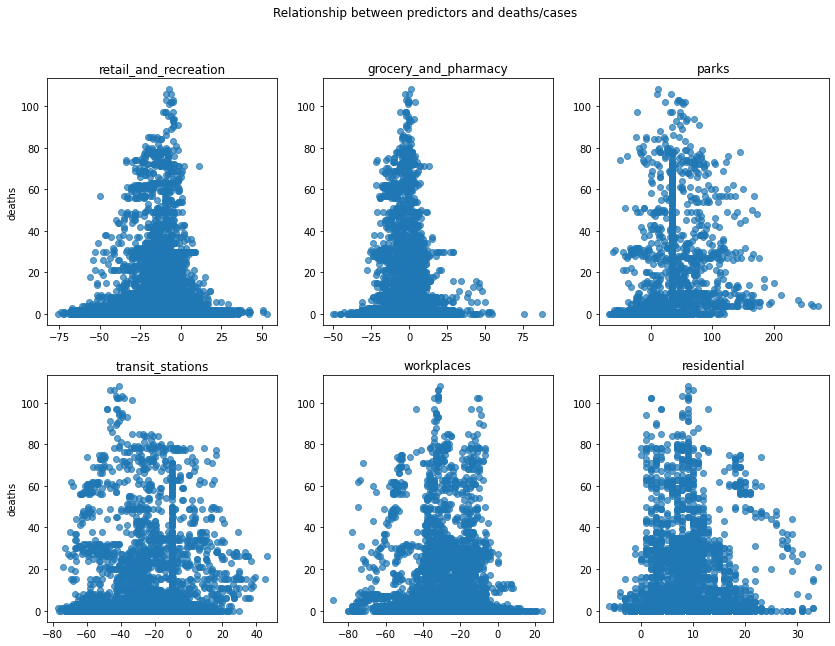

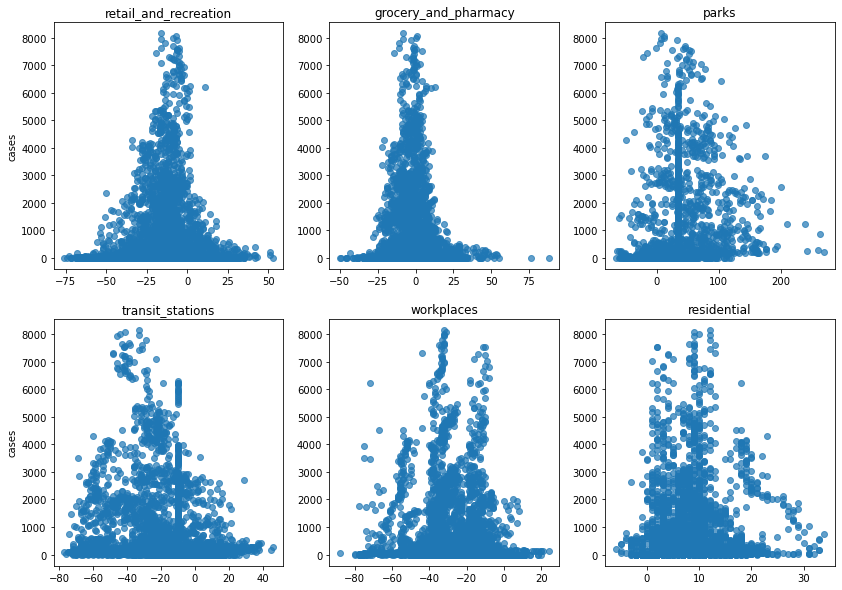

In [360]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 6 mobility predictors and deaths/cases")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['deaths'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("deaths")
    i += 1
    
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['cases'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("cases")
    i += 1

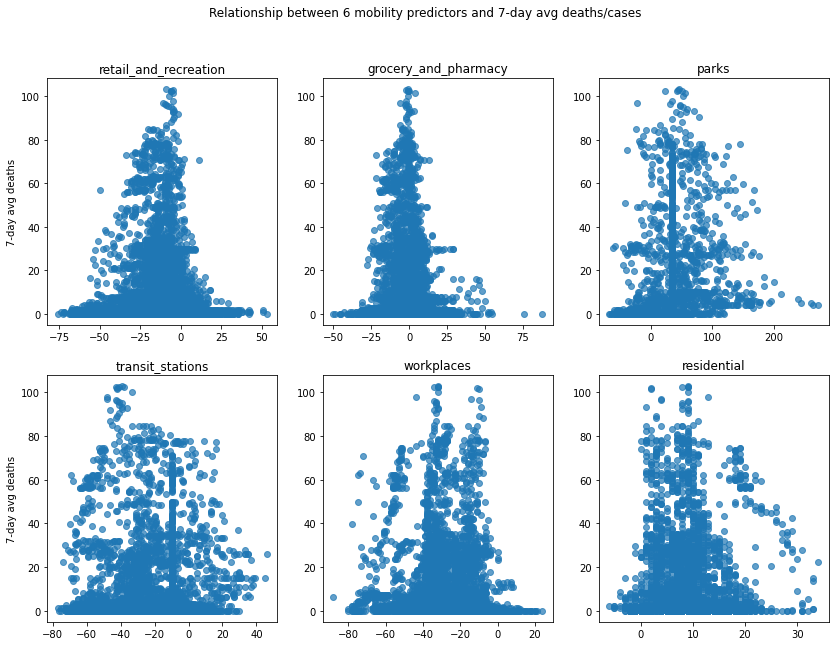

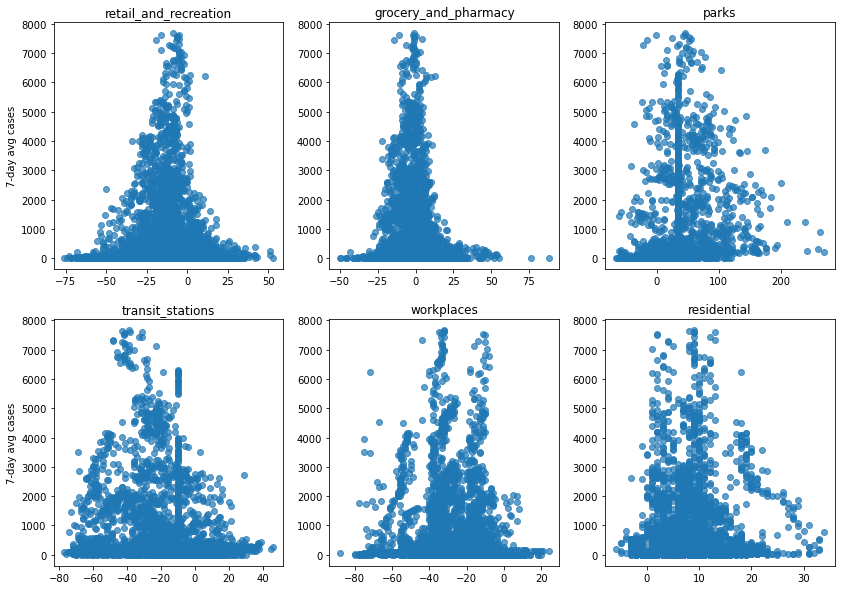

In [362]:
## let's check out the same but with 7-day average deaths and cases

fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 6 mobility predictors and 7-day avg deaths/cases")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['deaths_7day_ave'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("7-day avg deaths")
    i += 1
    
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['cases_7day_ave'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("7-day avg cases")
    i += 1

Now let's predict deaths on each of the 6 mobility predictors individually.

In [366]:
%%time

train_mses = {}
test_mses = {}

train_r2_dict = {}
test_r2_dict = {}

for i in range(len(predictors_list)):
    poly = PolynomialFeatures(4)
    x_train = poly.fit_transform(X_train[[predictors_list[i]]])

    # Train our model
    model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
    model.fit(x_train, y_train['deaths'])
    y_pred_train = model.predict(x_train)

    # Test our model
    x_test = poly.fit_transform(X_test[[predictors_list[i]]])
    y_pred_test = model.predict(x_test)
    
    # Calculate MSEs
    test_mse = mean_squared_error(y_pred_test, y_test["deaths"])
    train_mse = mean_squared_error(y_pred_train, y_train["deaths"])
    
    # Calculate r2
    test_r2 = r2_score(y_test["deaths"], y_pred_test)
    train_r2 = r2_score(y_train["deaths"], y_pred_train)
    
    train_mses.update([(predictors_list[i], train_mse)])
    test_mses.update([(predictors_list[i], test_mse)])
    
    train_r2_dict.update([(predictors_list[i], train_r2)])
    test_r2_dict.update([(predictors_list[i], test_r2)])

CPU times: user 109 ms, sys: 219 ms, total: 328 ms
Wall time: 50.6 ms


In [369]:
print("Train MSEs")
print(train_mses)
print("Test MSEs")
print(test_mses)
print("")
print("Train R^2")
print(train_r2_dict)
print("Test R^2")
print(test_r2_dict)

Train MSEs
{'retail_and_recreation': 269.2024684755076, 'grocery_and_pharmacy': 273.99831856341217, 'parks': 273.5264965091199, 'transit_stations': 254.34055163420408, 'workplaces': 276.01015667783537, 'residential': 276.54473541496606}
Test MSEs
{'retail_and_recreation': 265.97977248341806, 'grocery_and_pharmacy': 269.8720865305806, 'parks': 272.3526448034066, 'transit_stations': 245.5269794815114, 'workplaces': 272.9276422841646, 'residential': 270.8137672698257}

Train R^2
{'retail_and_recreation': 0.046626549592318045, 'grocery_and_pharmacy': 0.0296421728448234, 'parks': 0.031313118220719804, 'transit_stations': 0.09925963657292536, 'workplaces': 0.02251730116117534, 'residential': 0.020624104646228658}
Test R^2
{'retail_and_recreation': 0.048542225330206135, 'grocery_and_pharmacy': 0.03461871367722846, 'parks': 0.02574530788337659, 'transit_stations': 0.12170556678914812, 'workplaces': 0.02368843785008512, 'residential': 0.03125015127774222}


As we can see, predicting deaths on individual predictors does not work well. Let's try using all mobility predictors.

In [447]:
# Use this function to calculate a polynomial regression, given a list of predictors
def polynomial_regression(y_var_train, y_var_test, list_of_predictors):
    poly = PolynomialFeatures(4)
    x_train = poly.fit_transform(X_train[list_of_predictors])

    # Train our model
    model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
    model.fit(x_train, y_var_train)
    y_pred_train = model.predict(x_train)

    # Test our model
    x_test = poly.fit_transform(X_test[list_of_predictors])
    y_pred_test = model.predict(x_test)

    # Calculate MSEs
    test_mse = mean_squared_error(y_var_test, y_pred_test)
    train_mse = mean_squared_error(y_var_train, y_pred_train)

    # Calculate r2
    test_r2 = r2_score(y_var_test, y_pred_test)
    train_r2 = r2_score(y_var_train, y_pred_train)
    
    return train_mse, test_mse, train_r2, test_r2


In [448]:
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['deaths'], y_test['deaths'], predictors_list)

In [449]:
print(f"The MSE is {train_mse} for train")
print(f"r^2 is {train_r2} for train\n")

print(f"The MSE is {test_mse} for test")
print(f"r^2 is {test_r2} for test")

The MSE is 174.26428165480976 for train
r^2 is 0.38284763722670834 for train

The MSE is 198.1559540646157 for test
r^2 is 0.2911602963956852 for test


In [419]:
poly = PolynomialFeatures(4)
x_train = poly.fit_transform(X_train[predictors_list])

# Train our model
model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
model.fit(x_train, y_train['deaths'])
y_pred_train = model.predict(x_train)

# Test our model
x_test = poly.fit_transform(X_test[predictors_list])
y_pred_test = model.predict(x_test)

# Calculate MSEs
test_mse = mean_squared_error( y_test["deaths"], y_pred_test)
train_mse = mean_squared_error(y_train["deaths"], y_pred_train)

# Calculate r2
test_r2 = r2_score(y_test["deaths"], y_pred_test)
train_r2 = r2_score(y_train["deaths"], y_pred_train)


In [420]:
print(f"The MSE is {train_mse} for train")
print(f"r^2 is {train_r2} for train\n")

print(f"The MSE is {test_mse} for test")
print(f"r^2 is {test_r2} for test")

The MSE is 174.26428165480976 for train
r^2 is 0.38284763722670834 for train

The MSE is 198.1559540646157 for test
r^2 is 0.2911602963956852 for test


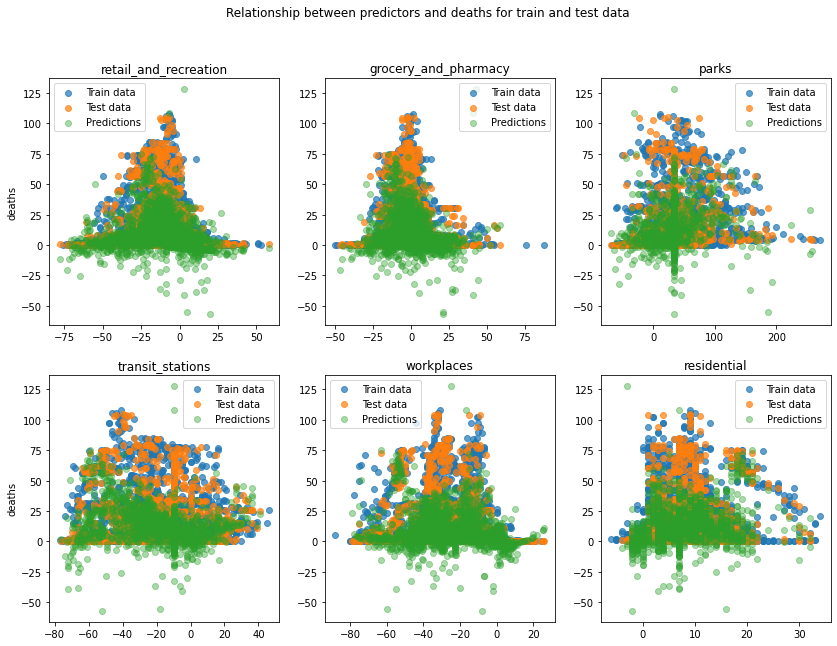

In [421]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between predictors and deaths for train and test data")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['deaths'], alpha=0.7, label="Train data")
    ax.scatter(X_test[predictors_list[i]], y_test['deaths'], alpha=0.7, label="Test data")
    ax.scatter(X_test[predictors_list[i]], y_pred_test, alpha=0.4, label="Predictions")
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("deaths")
    i += 1
    ax.legend()


Now let's analyze using a bagging regression model. Use all mobility predictors and predict deaths.

In [373]:
# Specify the number of bootstraps as 30
num_bootstraps = 80

# Specify the maximum depth of the decision tree as 3
max_depth = 65

# Define the Bagging Regressor Model
# Use Decision Tree as your base estimator with depth as mentioned in max_depth
# Initialise number of estimators using the num_bootstraps value
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps)
                        
# Fit the model on the train data
model.fit(X_train[predictors_list], y_train['deaths'])

# Make predictions
print("The below is for predicting deaths")
y_train_pred = model.predict(X_train[predictors_list])
print(f"The MSE for train set on all the predictors is {mean_squared_error(y_train['deaths'], y_train_pred)}")
print(f"r^2 on all the predictors is {r2_score(y_train['deaths'], y_train_pred)} for train")

y_test_pred = model.predict(X_test[predictors_list])
print(f"The MSE for test set on all the predictors is {mean_squared_error(y_test['deaths'], y_test_pred)}")
print(f"r^2 on all the predictors is {r2_score(y_test['deaths'], y_test_pred)} for test")

The below is for predicting deaths
The MSE for train set on all the predictors is 16.609114362749015
r^2 on all the predictors is 0.9411792590242519 for train
The MSE for test set on all the predictors is 98.87373035878873
r^2 on all the predictors is 0.6463107755070389 for test


Now let's do the same to predict cases. Again, use all mobility predictors.

In [374]:
# Specify the number of bootstraps as 30
num_bootstraps = 80

# Specify the maximum depth of the decision tree as 3
max_depth = 65

# Define the Bagging Regressor Model
# Use Decision Tree as your base estimator with depth as mentioned in max_depth
# Initialise number of estimators using the num_bootstraps value
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps)
                        
# Fit the model on the train data
model.fit(X_train[predictors_list], y_train['cases'])

# Make predictions
print("The below is for predicting cases")
y_train_pred = model.predict(X_train[predictors_list])
print(f"The MSE for train set on all the predictors is {mean_squared_error(y_train['cases'], y_train_pred)}")
print(f"r^2 on all the predictors is {r2_score(y_train['cases'], y_train_pred)} for train")

y_test_pred = model.predict(X_test[predictors_list])
print(f"The MSE for test set on all the predictors is {mean_squared_error(y_test['cases'], y_test_pred)}")
print(f"r^2 on all the predictors is {r2_score(y_test['cases'], y_test_pred)} for test")

The below is for predicting cases
The MSE for train set on all the predictors is 52112.894682106584
r^2 on all the predictors is 0.9559564547798989 for train
The MSE for test set on all the predictors is 351046.3406240553
r^2 on all the predictors is 0.7019250677271146 for test


As we can see, the test data's r^2 improved a bit. It was around 0.64 when predicting deaths, but now it is around 0.70 when predicting cases. This suggests that using same-day mobility data is a better indicator for predicting cases rather than deaths.

Now let's fit on the individual mobility predictors again, and see what happens.

In [375]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    # Specify the number of bootstraps as 30
    num_bootstraps = 80

    # Specify the maximum depth of the decision tree as 3
    max_depth = 65

    # Define the Bagging Regressor Model
    # Use Decision Tree as your base estimator with depth as mentioned in max_depth
    # Initialise number of estimators using the num_bootstraps value
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps)

    # Fit the model on the train data
    model.fit(X_train[[predictors_list[i]]], y_train['deaths'])

    y_train_pred = model.predict(X_train[[predictors_list[i]]])
    y_test_pred = model.predict(X_test[[predictors_list[i]]])
    
    mse_train = mean_squared_error(y_train['deaths'], y_train_pred)
    mse_test = mean_squared_error(y_test['deaths'], y_test_pred)
    
    r2_train = r2_score(y_train['deaths'], y_train_pred)
    r2_test = r2_score(y_test['deaths'], y_test_pred)

    bagg_mses_train.update([(predictors_list[i], mse_train)])
    bagg_mses_test.update([(predictors_list[i], mse_test)])
    
    bagg_r2_train.update([(predictors_list[i], r2_train)])
    bagg_r2_test.update([(predictors_list[i], r2_test)])
    
    train_list_mse.append(mse_train)
    test_list_mse.append(mse_test)
    
    train_list_r2.append(r2_train)
    test_list_r2.append(r2_test)
    

In [376]:
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)


Train set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,242.619436,255.544197,235.339791,235.653191,259.631649,217.561758
R2,0.140770,0.094997,0.166550,0.165440,0.080521,0.229511


Test set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,240.979293,256.398650,271.919131,244.260569,258.247430,229.166079
R2,0.137973,0.082816,0.027296,0.126236,0.076202,0.180231


As expected, the MSE is around the same, but the r^2 is much lower than when using all the predictors. This suggests we are better served to used all mobility predictors, however, let's plot the MSEs and r^2 values for the 6 mobility predictors and see if we can begin to tell which ones are better than others.

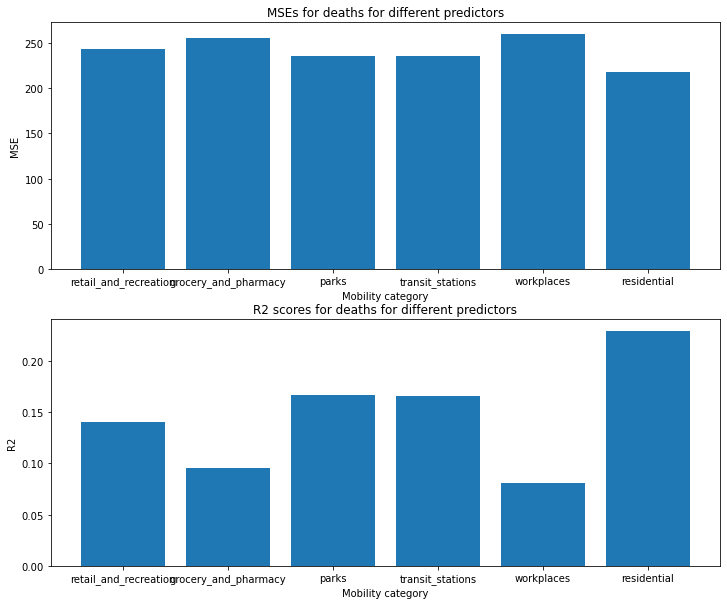

In [377]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(predictors_list, train_list_mse)
axs[0].set_title("MSEs for deaths for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(predictors_list, train_list_r2)
axs[1].set_title("R2 scores for deaths for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")


fig.show()

Now do the same but examine cases instead of deaths. We expect the same trend - i.e. that parks, transit stations, and residential are better predictors than the other 3.

In [378]:

bagg_mses_train_c = {}
bagg_mses_test_c = {}

bagg_r2_train_c = {}
bagg_r2_test_c = {}

train_list_mse_c = []
test_list_mse_c = []

train_list_r2_c = []
test_list_r2_c = []

for i in range(6):
    # Specify the number of bootstraps as 30
    num_bootstraps = 80

    # Specify the maximum depth of the decision tree as 3
    max_depth = 65

    # Define the Bagging Regressor Model
    # Use Decision Tree as your base estimator with depth as mentioned in max_depth
    # Initialise number of estimators using the num_bootstraps value
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps)

    # Fit the model on the train data
    model.fit(X_train[[predictors_list[i]]], y_train['cases'])

    y_train_pred = model.predict(X_train[[predictors_list[i]]])
    y_test_pred = model.predict(X_test[[predictors_list[i]]])
    
    mse_train = mean_squared_error(y_train['cases'], y_train_pred)
    mse_test = mean_squared_error(y_test['cases'], y_test_pred)
    
    r2_train = r2_score(y_train['cases'], y_train_pred)
    r2_test = r2_score(y_test['cases'], y_test_pred)

    bagg_mses_train_c.update([(predictors_list[i], mse_train)])
    bagg_mses_test_c.update([(predictors_list[i], mse_test)])

    bagg_r2_train_c.update([(predictors_list[i], r2_train)])
    bagg_r2_test_c.update([(predictors_list[i], r2_test)])
    
    train_list_mse_c.append(mse_train)
    test_list_mse_c.append(mse_test)
    
    train_list_r2_c.append(r2_train)
    test_list_r2_c.append(r2_test)

In [379]:
bagg_mses_train_c_df = pd.DataFrame(data=[bagg_mses_train_c, bagg_r2_train_c], index=['MSE', 'R2'])
bagg_mses_test_c_df = pd.DataFrame(data=[bagg_mses_test_c, bagg_r2_test_c], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_c_df)

print("Test set:")
display(bagg_mses_test_c_df)

Train set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,1.038069e+06,1.067744e+06,917485.605575,927208.125618,1.091886e+06,887492.479711
R2,1.226693e-01,9.758963e-02,0.224581,0.216364,7.718595e-02,0.249930


Test set:


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
MSE,1.035783e+06,1.067458e+06,1.117420e+06,968381.780884,1.090666e+06,914807.911383
R2,1.205123e-01,9.361695e-02,5.119423e-02,0.177743,7.391048e-02,0.223233


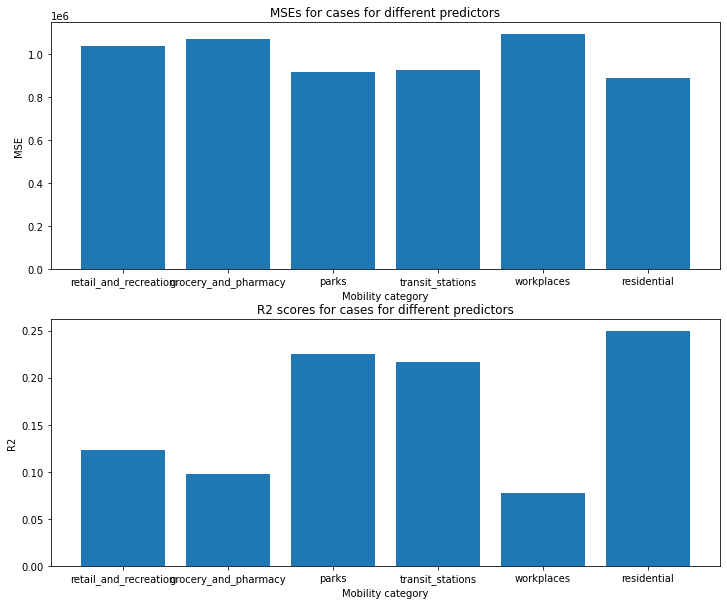

In [380]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(predictors_list, train_list_mse_c)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(predictors_list, train_list_r2_c)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()

As expected, the trend that parks and transit stations are better remains. This time it is even more prominent.

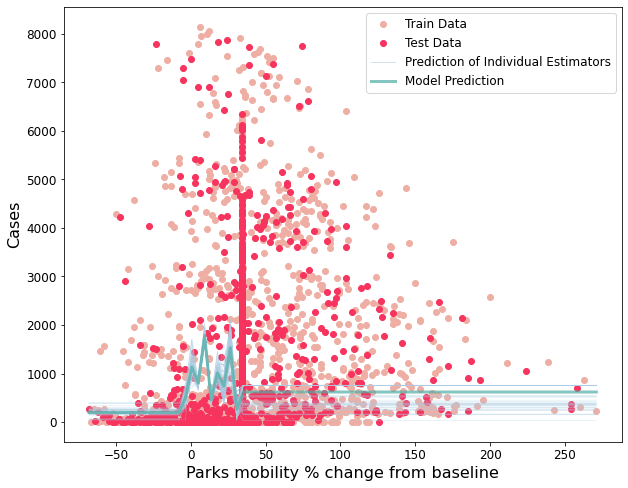

In [382]:
x = X[['parks']].values
x_train = X_train[['parks']]
x_test = X_test[['parks']]

plt.figure(figsize=(10,8))

xrange = np.linspace(x.min(),x.max(),80).reshape(-1,1)
plt.plot(x_train,y_train['cases'],'o',color='#EFAEA4', markersize=6, label="Train Data")
plt.plot(x_test,y_test['cases'],'o',color='#F6345E', markersize=6, label="Test Data")

plt.xlim()
for i in model.estimators_:
    y_pred1 = i.predict(xrange)
    plt.plot(xrange,y_pred1,alpha=0.5,linewidth=0.5,color = '#ABCCE3')
plt.plot(xrange,y_pred1,alpha=0.6,linewidth=1,color = '#ABCCE3',label="Prediction of Individual Estimators")


y_pred = model.predict(xrange)
plt.plot(xrange,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='Model Prediction')
plt.xlabel("Parks mobility % change from baseline", fontsize=16)
plt.ylabel("Cases", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

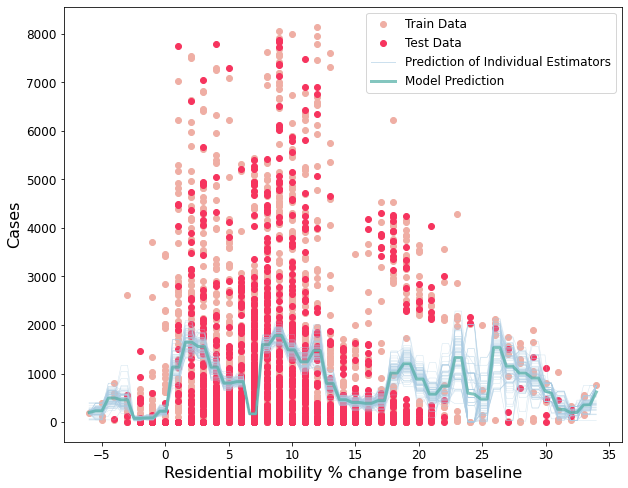

In [383]:
# Now let's look at residential
x = X[['residential']].values
x_train = X_train[['residential']]
x_test = X_test[['residential']]

plt.figure(figsize=(10,8))

xrange = np.linspace(x.min(),x.max(),80).reshape(-1,1)
plt.plot(x_train,y_train['cases'],'o',color='#EFAEA4', markersize=6, label="Train Data")
plt.plot(x_test,y_test['cases'],'o',color='#F6345E', markersize=6, label="Test Data")

plt.xlim()
for i in model.estimators_:
    y_pred1 = i.predict(xrange)
    plt.plot(xrange,y_pred1,alpha=0.5,linewidth=0.5,color = '#ABCCE3')
plt.plot(xrange,y_pred1,alpha=0.6,linewidth=1,color = '#ABCCE3',label="Prediction of Individual Estimators")


y_pred = model.predict(xrange)
plt.plot(xrange,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='Model Prediction')
plt.xlabel("Residential mobility % change from baseline", fontsize=16)
plt.ylabel("Cases", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

This model is not much better. Let's start predicting using average day mobility.

In [408]:
predictors_list

['retail_and_recreation',
 'grocery_and_pharmacy',
 'parks',
 'transit_stations',
 'workplaces',
 'residential']

<div class="exercise"><b>PART 2.</b> Let's look at 7-day average mobility.</div>

In [409]:
mobility_predictors_all = predictors_list.copy()
mobility_predictors_all.append('retail_and_recreation_7day_ave')
mobility_predictors_all.append('grocery_and_pharmacy_7day_ave')
mobility_predictors_all.append('parks_7day_ave')
mobility_predictors_all.append('transit_stations_7day_ave')
mobility_predictors_all.append('workplaces_7day_ave')
mobility_predictors_all.append('residential_7day_ave')

In [410]:
print(mobility_predictors_all)

['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'retail_and_recreation_7day_ave', 'grocery_and_pharmacy_7day_ave', 'parks_7day_ave', 'transit_stations_7day_ave', 'workplaces_7day_ave', 'residential_7day_ave']


In [411]:
poly = PolynomialFeatures(4)
x_train = poly.fit_transform(X_train[mobility_predictors_all])

# Train our model
model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
model.fit(x_train, y_train['deaths'])
y_pred_train = model.predict(x_train)

# Test our model
x_test = poly.fit_transform(X_test[mobility_predictors_all])
y_pred_test = model.predict(x_test)

# Calculate MSEs
test_mse = mean_squared_error(y_test["deaths"], y_pred_test)
train_mse = mean_squared_error(y_train["deaths"], y_pred_train)

# Calculate r2
test_r2 = r2_score(y_test["deaths"], y_pred_test)
train_r2 = r2_score(y_train["deaths"], y_pred_train)

print(f"The MSE is {train_mse} for train")
print(f"r^2 is {train_r2} for train\n")

print(f"The MSE is {test_mse} for test")
print(f"r^2 is {test_r2} for test")

The MSE is 73.45615190806119 for train
r^2 is 0.7398569730996702 for train

The MSE is 1369.3174605188726 for test
r^2 is -3.8982963314738655 for test


So what we see here is a negative r^2 for test, which means that our model is actually terrible. Let's try predicting on just the 7-day avg mobility predictors and see what happens.

In [405]:
mobility_predictors = ['retail_and_recreation_7day_ave', 'grocery_and_pharmacy_7day_ave', 'parks_7day_ave', 'transit_stations_7day_ave', 'workplaces_7day_ave', 'residential_7day_ave']

In [423]:
poly = PolynomialFeatures(4)
x_train = poly.fit_transform(X_train[mobility_predictors])

# Train our model
model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
model.fit(x_train, y_train['deaths'])
y_pred_train = model.predict(x_train)

# Test our model
x_test = poly.fit_transform(X_test[mobility_predictors])
y_pred_test = model.predict(x_test)

# Calculate MSEs
test_mse = mean_squared_error(y_test["deaths"], y_pred_test)
train_mse = mean_squared_error(y_train["deaths"], y_pred_train)

# Calculate r2
test_r2 = r2_score(y_test["deaths"], y_pred_test)
train_r2 = r2_score(y_train["deaths"], y_pred_train)

print("This data is predicting deaths.\n")
print(f"The MSE is {train_mse} for train")
print(f"r^2 is {train_r2} for train\n")

print(f"The MSE is {test_mse} for test")
print(f"r^2 is {test_r2} for test")

This data is predicting deaths.

The MSE is 147.59904703971114 for train
r^2 is 0.477281863164127 for train

The MSE is 156.471042417011 for test
r^2 is 0.4402747681587946 for test


This is much better. Previously, when we just used the 6 mobility predictors to predict deaths, we got that the train MSE was around 174, while the test MSE was around 198. We also got that the train r^2 is around 0.383 and the test r^2 is around 0.291. Now, we see much better results.

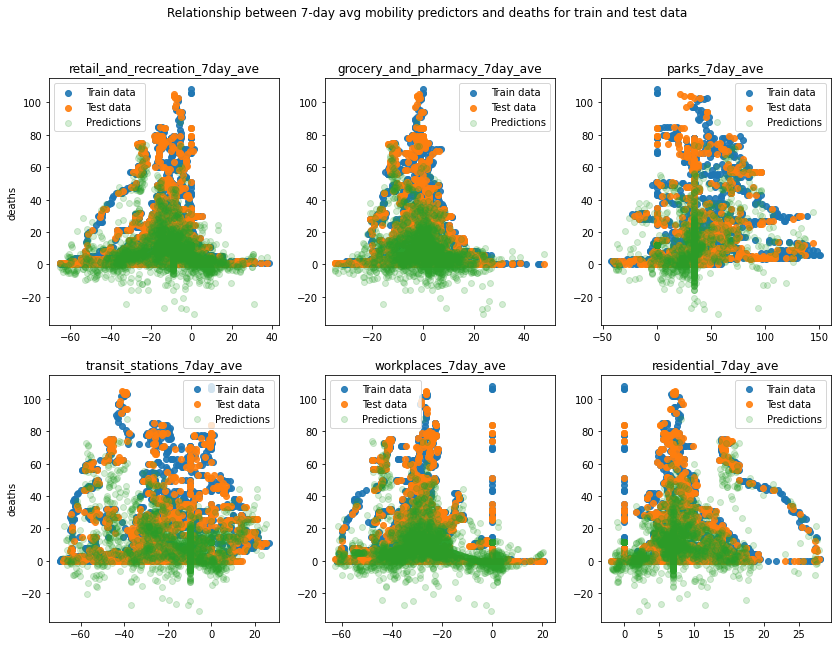

In [425]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 7-day avg mobility predictors and deaths for train and test data")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[mobility_predictors[i]], y_train['deaths'], alpha=0.9, label="Train data")
    ax.scatter(X_test[mobility_predictors[i]], y_test['deaths'], alpha=0.9, label="Test data")
    ax.scatter(X_test[mobility_predictors[i]], y_pred_test, alpha=0.2, label="Predictions")
    ax.set_title(mobility_predictors[i])
    if i == 0 or i == 3:
        ax.set_ylabel("deaths")
    i += 1
    ax.legend()

In [427]:
poly = PolynomialFeatures(4)
x_train = poly.fit_transform(X_train[mobility_predictors])

# Train our model
model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
model.fit(x_train, y_train['cases'])
y_pred_train = model.predict(x_train)

# Test our model
x_test = poly.fit_transform(X_test[mobility_predictors])
y_pred_test = model.predict(x_test)

# Calculate MSEs
test_mse = mean_squared_error(y_test["cases"], y_pred_test)
train_mse = mean_squared_error(y_train["cases"], y_pred_train)

# Calculate r2
test_r2 = r2_score(y_test["cases"], y_pred_test)
train_r2 = r2_score(y_train["cases"], y_pred_train)

print("This data is predicting cases.\n")
print(f"The MSE is {train_mse} for train")
print(f"r^2 is {train_r2} for train\n")

print(f"The MSE is {test_mse} for test")
print(f"r^2 is {test_r2} for test")

This data is predicting cases.

The MSE is 523763.53165466926 for train
r^2 is 0.5573379116283663 for train

The MSE is 598027.3731314794 for test
r^2 is 0.49221242863090464 for test


We again see a relatively nice r^2. Again this show how using our mobility predictors to predict cases results in a better and more accurate model.

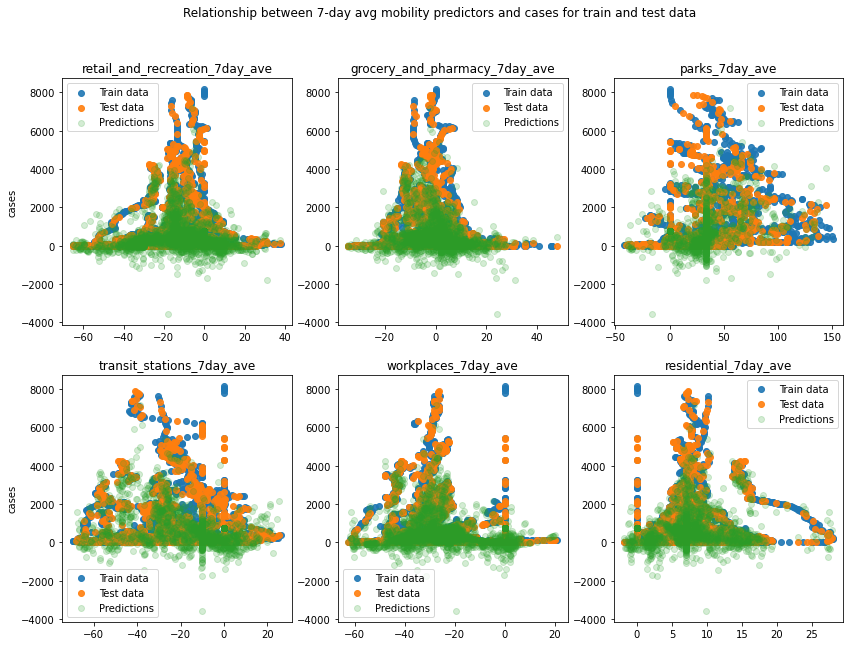

In [429]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

fig.suptitle("Relationship between 7-day avg mobility predictors and cases for train and test data")

i = 0
for ax in axs.flat:
    ax.scatter(X_train[mobility_predictors[i]], y_train['cases'], alpha=0.9, label="Train data")
    ax.scatter(X_test[mobility_predictors[i]], y_test['cases'], alpha=0.9, label="Test data")
    ax.scatter(X_test[mobility_predictors[i]], y_pred_test, alpha=0.2, label="Predictions")
    ax.set_title(mobility_predictors[i])
    if i == 0 or i == 3:
        ax.set_ylabel("cases")
    i += 1
    ax.legend()

Now let's fit a bagging regressor model using all 7-day average predictors.

In [431]:
num_bootstraps = 80
max_depth = 65

# Define the Bagging Regressor Model
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps)
                        
# Fit the model on the train data
model.fit(X_train[mobility_predictors], y_train['cases'])

# Make predictions
print("The below is for predicting cases")
y_train_pred = model.predict(X_train[mobility_predictors])
print(f"The MSE for train set on all the predictors is {mean_squared_error(y_train['cases'], y_train_pred)}")
print(f"r^2 on all the predictors is {r2_score(y_train['cases'], y_train_pred)} for train")

y_test_pred = model.predict(X_test[mobility_predictors])
print(f"The MSE for test set on all the predictors is {mean_squared_error(y_test['cases'], y_test_pred)}")
print(f"r^2 on all the predictors is {r2_score(y_test['cases'], y_test_pred)} for test")

The below is for predicting cases
The MSE for train set on all the predictors is 81313.35992311536
r^2 on all the predictors is 0.9312774953949781 for train
The MSE for test set on all the predictors is 130699.06290244985
r^2 on all the predictors is 0.8890228730100947 for test


Previously, when predicting on current day mobility, we saw MSE on train data around 52000, and an MSE on test data of about 351000. Meanwhile, the r^2 on train was about 0.955, and on the test data was around 0.70. So, what we observe is that while the train r^2 decreased a little, the r^2 on test data increased from around 70% to almost 90%, which is a good improvement.

In [436]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    num_bootstraps = 80
    max_depth = 65

    # Define the Bagging Regressor Model
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth), n_estimators=num_bootstraps)

    # Fit the model on the train data
    model.fit(X_train[[mobility_predictors[i]]], y_train['cases'])

    y_train_pred = model.predict(X_train[[mobility_predictors[i]]])
    y_test_pred = model.predict(X_test[[mobility_predictors[i]]])
    
    mse_train = mean_squared_error(y_train['cases'], y_train_pred)
    mse_test = mean_squared_error(y_test['cases'], y_test_pred)
    
    r2_train = r2_score(y_train['cases'], y_train_pred)
    r2_test = r2_score(y_test['cases'], y_test_pred)

    bagg_mses_train.update([(mobility_predictors[i], mse_train)])
    bagg_mses_test.update([(mobility_predictors[i], mse_test)])
    
    bagg_r2_train.update([(mobility_predictors[i], r2_train)])
    bagg_r2_test.update([(mobility_predictors[i], r2_test)])
    
    train_list_mse.append(mse_train)
    test_list_mse.append(mse_test)
    
    train_list_r2.append(r2_train)
    test_list_r2.append(r2_test)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)
    

Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,969080.618775,1.007345e+06,713864.571406,788187.512039,1.047268e+06,862470.792196
R2,0.180975,1.486361e-01,0.396673,0.333858,1.148952e-01,0.271077


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,1.078710e+06,1.076508e+06,1.138454e+06,1.081844e+06,1.089457e+06,929666.822633
R2,8.406254e-02,8.593275e-02,3.333381e-02,8.140128e-02,7.493717e-02,0.210616


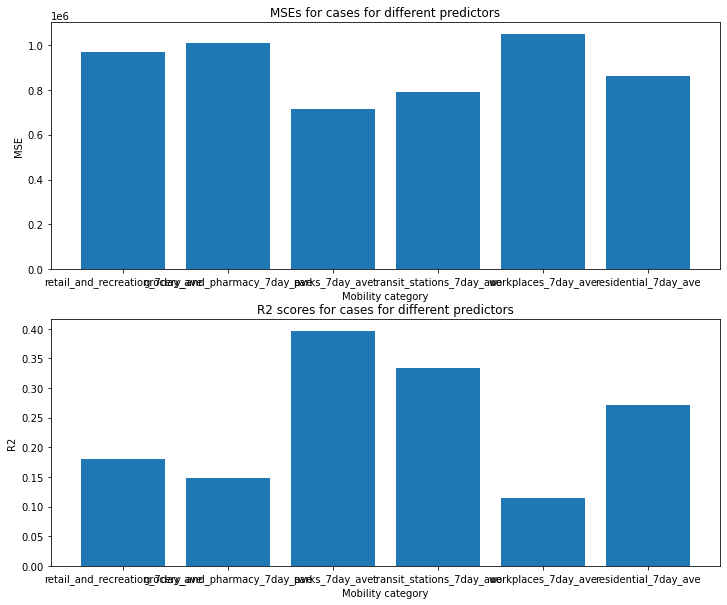

In [437]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

axs[0].bar(mobility_predictors, train_list_mse)
axs[0].set_title("MSEs for cases for different predictors")
axs[0].set_xlabel("Mobility category")
axs[0].set_ylabel("MSE")

axs[1].bar(mobility_predictors, train_list_r2)
axs[1].set_title("R2 scores for cases for different predictors")
axs[1].set_xlabel("Mobility category")
axs[1].set_ylabel("R2")

fig.show()

Again, we see the trend that parks, transit stations, and residential mobility tend to be the better predictors of the 6.

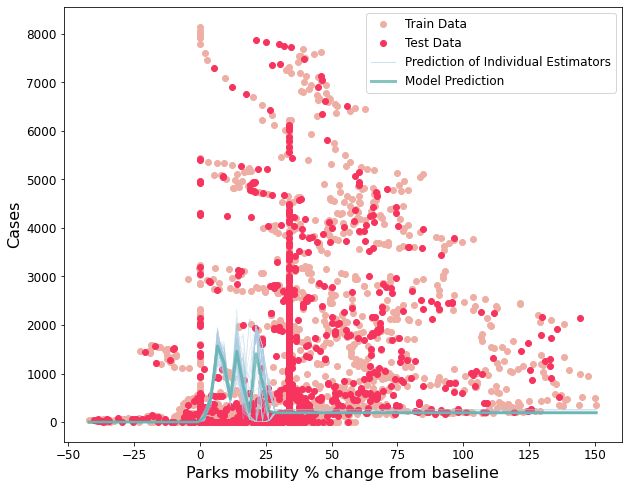

In [439]:
x = X[['parks_7day_ave']].values
x_train = X_train[['parks_7day_ave']]
x_test = X_test[['parks_7day_ave']]

plt.figure(figsize=(10,8))

xrange = np.linspace(x.min(),x.max(),80).reshape(-1,1)
plt.plot(x_train,y_train['cases'],'o',color='#EFAEA4', markersize=6, label="Train Data")
plt.plot(x_test,y_test['cases'],'o',color='#F6345E', markersize=6, label="Test Data")

plt.xlim()
for i in model.estimators_:
    y_pred1 = i.predict(xrange)
    plt.plot(xrange,y_pred1,alpha=0.5,linewidth=0.5,color = '#ABCCE3')
plt.plot(xrange,y_pred1,alpha=0.6,linewidth=1,color = '#ABCCE3',label="Prediction of Individual Estimators")

y_pred = model.predict(xrange)
plt.plot(xrange,y_pred,alpha=0.7,linewidth=3,color='#50AEA4', label='Model Prediction')
plt.xlabel("Parks mobility % change from baseline", fontsize=16)
plt.ylabel("Cases", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

<div class="exercise"><b>PART 3.</b> Let's look at 7-day average mobility, and also include facemask data.</div>

In [440]:
df.head()

,sub_region_1,sub_region_2,census_fips_code,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,...,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave,facemask_never,facemask_rarely,facemask_sometimes,facemask_frequently,facemask_always,facemask_score
0,Alaska,Anchorage,2020.0,2020-02-15,5,3,11,3,0,0,...,0.000000,0.000000,0.000000,0.000000,0.042,0.05,0.049,0.196,0.663,4.388
1,Alaska,Anchorage,2020.0,2020-02-16,15,3,43,6,3,-1,...,0.000000,0.000000,0.000000,0.000000,0.042,0.05,0.049,0.196,0.663,4.388
2,Alaska,Anchorage,2020.0,2020-02-17,4,0,-2,-10,-36,10,...,0.000000,0.000000,0.000000,0.000000,0.042,0.05,0.049,0.196,0.663,4.388
3,Alaska,Anchorage,2020.0,2020-02-18,-5,-1,-19,3,1,2,...,2.571429,1.428571,-3.428571,1.714286,0.042,0.05,0.049,0.196,0.663,4.388
4,Alaska,Anchorage,2020.0,2020-02-19,-1,-3,-8,5,1,1,...,2.714286,1.428571,-3.000000,1.571429,0.042,0.05,0.049,0.196,0.663,4.388


In [441]:
facemask_predictors = ['facemask_never', 'facemask_rarely', 'facemask_sometimes', 'facemask_frequently', 'facemask_always', 'facemask_score']

In [443]:
# combine these and 7-day Avg mobility into a new list.
all_predictors = mobility_predictors + facemask_predictors

In [444]:
all_predictors

['retail_and_recreation_7day_ave',
 'grocery_and_pharmacy_7day_ave',
 'parks_7day_ave',
 'transit_stations_7day_ave',
 'workplaces_7day_ave',
 'residential_7day_ave',
 'facemask_never',
 'facemask_rarely',
 'facemask_sometimes',
 'facemask_frequently',
 'facemask_always',
 'facemask_score']

In [445]:
poly = PolynomialFeatures(4)
x_train = poly.fit_transform(X_train[all_predictors])

# Train our model
model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
model.fit(x_train, y_train['deaths'])
y_pred_train = model.predict(x_train)

# Test our model
x_test = poly.fit_transform(X_test[all_predictors])
y_pred_test = model.predict(x_test)

# Calculate MSEs
test_mse = mean_squared_error(y_test["deaths"], y_pred_test)
train_mse = mean_squared_error(y_train["deaths"], y_pred_train)

# Calculate r2
test_r2 = r2_score(y_test["deaths"], y_pred_test)
train_r2 = r2_score(y_train["deaths"], y_pred_train)

print("This data is predicting deaths.\n")
print(f"The MSE is {train_mse} for train")
print(f"r^2 is {train_r2} for train\n")

print(f"The MSE is {test_mse} for test")
print(f"r^2 is {test_r2} for test")

This data is predicting deaths.

The MSE is 10.993848848997263 for train
r^2 is 0.9610655739162264 for train

The MSE is 39.16439186824006 for test
r^2 is 0.8599018835705841 for test


Previously, when just using 

The MSE is 147.59904703971114 for train
r^2 is 0.477281863164127 for train

The MSE is 156.471042417011 for test
r^2 is 0.4402747681587946 for test